In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Conv2DTranspose, Lambda, Activation, Reshape, UpSampling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as K

import matplotlib.image as mpimg

from skimage import color
import skimage.io

import glob

from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.neighbors import KNeighborsClassifier

from collections import OrderedDict

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import cv2 as cv
import gc
import os, random, time

from keras.regularizers import l2
import matplotlib.gridspec as gridspec
import matplotlib.pylab as plt
import sklearn.neighbors as nn
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d
from scipy.signal import gaussian, convolve

from skimage.color import rgb2gray
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10853805994770143144
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 18139546857216611431
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8594663444091352769
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15701401920
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17466814942560953335
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_id = '1rNJp1n99O8EJsRqxSZc0V4VWpSd4esyY'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('train640PNG.zip')

file_id = '1OOea8RVCIz0P_ccn9fML_sc7DBuLvQqV'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('valid640PNG.zip')

file_id = '1_wHWcS7mgkjH8UCbDnAkr74J4TMMLkvS'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('pixel_bin_weights512x512.npy')

file_id = '1GHojtbsQ2cJjMMZffiNA6T3ZOuBvVQXt'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('train_mean_std640.zip')

!unzip train640PNG.zip -d trainingset/
!unzip valid640PNG.zip -d validationset/
!unzip train_mean_std640.zip

Archive:  train640PNG.zip
  inflating: trainingset/795.png     
  inflating: trainingset/001.png     
  inflating: trainingset/002.png     
  inflating: trainingset/003.png     
  inflating: trainingset/004.png     
  inflating: trainingset/005.png     
  inflating: trainingset/006.png     
  inflating: trainingset/007.png     
  inflating: trainingset/008.png     
  inflating: trainingset/009.png     
  inflating: trainingset/010.png     
  inflating: trainingset/011.png     
  inflating: trainingset/012.png     
  inflating: trainingset/013.png     
  inflating: trainingset/014.png     
  inflating: trainingset/015.png     
  inflating: trainingset/016.png     
  inflating: trainingset/017.png     
  inflating: trainingset/018.png     
  inflating: trainingset/019.png     
  inflating: trainingset/020.png     
  inflating: trainingset/021.png     
  inflating: trainingset/022.png     
  inflating: trainingset/023.png     
  inflating: trainingset/024.png     
  inflating: trainingset

In [0]:
def point_lab2xyz(L,a,b):
  #D65
  reference_X = 95.047
  reference_Y = 100.000
  reference_Z = 108.883

  var_Y = ( L + 16 ) / 116
  var_X = a / 500 + var_Y
  var_Z = var_Y - b / 200

  if (var_Y**3  > 0.008856 ):
    var_Y = var_Y**3
  else:
    var_Y = (var_Y - 16 / 116) / 7.787
  
  if (var_X**3  > 0.008856):
    var_X = var_X**3
  else:
    var_X = (var_X - 16 / 116) / 7.787
  
  if (var_Z**3  > 0.008856):
    var_Z = var_Z**3
  else:
    var_Z = (var_Z - 16 / 116) / 7.787

  X = var_X * reference_X
  Y = var_Y * reference_Y
  Z = var_Z * reference_Z
  return np.asarray([X,Y,Z])

def point_xyz2rgb(X,Y,Z):
  var_X = X / 100
  var_Y = Y / 100
  var_Z = Z / 100

  var_R = var_X *  3.2406 + var_Y * -1.5372 + var_Z * -0.4986
  var_G = var_X * -0.9689 + var_Y *  1.8758 + var_Z *  0.0415
  var_B = var_X *  0.0557 + var_Y * -0.2040 + var_Z *  1.0570

  if (var_R > 0.0031308):
    var_R = 1.055 * ( var_R ** ( 1 / 2.4 ) ) - 0.055
  else:                   
    var_R = 12.92 * var_R

  if (var_G > 0.0031308):
    var_G = 1.055 * ( var_G ** ( 1 / 2.4 ) ) - 0.055
  else:                   
    var_G = 12.92 * var_G

  if (var_B > 0.0031308):
    var_B = 1.055 * ( var_B ** ( 1 / 2.4 ) ) - 0.055
  else:              
   var_B = 12.92 * var_B

  sR = var_R * 255
  sG = var_G * 255
  sB = var_B * 255

  return np.asarray([sR,sG,sB])
  
#definizione dello spazio a,b
max_range_a = 230
max_range_b = max_range_a
bins_a = 23
bins_b = bins_a
total_bins = bins_a * bins_b
size_bin_a = max_range_a/bins_a
size_bin_b = max_range_b/bins_b

#restituisce un'hashmap che contiene solo i bins visibili in RGB (detti "in gamut") Le classi sono numerate da 0 a N-1
def get_bins_in_gamut():
  bins_gamut = OrderedDict()
  c = 0
  #enumera tutti le possibili bins formabili sulle componenti a,b
  for i in range(0, total_bins):
    (a, b) = get_central_ab_from_bin(i)
    #questo valore di (a,b) è presente nel gamut?
    if(is_in_gamut(a,b)):
      bins_gamut[c] = (a,b)
      c += 1
  return bins_gamut

#Dato un valore di bin, restituisce le componenti [a,b] centrali del bin
def get_central_ab_from_bin(c):
  a = np.trunc(c / bins_a)
  mina = a * size_bin_a
  maxa = a * size_bin_a + size_bin_a
  risa = (mina + maxa)/2 - max_range_a/2

  b = c % bins_b
  minb = b * size_bin_b
  maxb = b * size_bin_b + size_bin_b
  risb = (minb + maxb)/2 - max_range_b/2

  return np.array([risa,risb])

#definisce se un punto (a,b) è presente nel gamut RGB oppure no
def is_in_gamut(a,b):
  L = 50
  
  xyz = point_lab2xyz(L,a,b)
  rgb = point_xyz2rgb(xyz[0],xyz[1],xyz[2])

  if (np.any(rgb < 0) or np.any(rgb > 255)):
    return False

  return True

classes_dict = get_bins_in_gamut()
inv_classes_dict = {v: k for k, v in classes_dict.items()}
n_classes = len(classes_dict.keys())

#Caricamento delle immagini e trasformazione in tensori RGB
#La funzione prende le immagini in PNG da una cartella e manda in output un tensore di immagini in formato RGB
def load_images_in_RGB(dataset_folder, size_img):
  images_uri = glob.glob(dataset_folder+"*.png")
  nImages = len(images_uri)
  tensor_images = np.empty((nImages,size_img,size_img,3),dtype="uint8")

  i = 0
  for image_uri in images_uri:
    img = skimage.io.imread(image_uri)
    tensor_images[i] = np.round(skimage.transform.resize(img,(size_img,size_img),anti_aliasing=True) * 255)

    i += 1
    if(i % 100 == 0):
      print(i)

  return tensor_images

#Trasformazione da tensore RGB in tensore Lab
#Produce in output un tensore di immagini in formato Lab
def from_RGB_to_Lab(tensor_images):
  #print("TRASFORMO " + str(tensor_images.shape[0]) +" IMMAGINI DA SPAZIO RGB IN SPAZIO LAB")

  nImages = tensor_images.shape[0]
  tensor_images_lab = np.empty((nImages,tensor_images.shape[1],tensor_images.shape[2],3),dtype="float64")

  i = 0
  for img in range(0, nImages):
    tensor_images_lab[img] = skimage.color.rgb2lab(tensor_images[img], illuminant = "D65")
    i += 1
    if i % 100 == 0:
      print(i)

  return tensor_images_lab

#facciamo un resize delle componenti ab per produrre le etichette
def resize_images_ab(images_ab, size):
  results = np.empty((images_ab.shape[0],size,size,2))

  for i in range(0,images_ab.shape[0]):
    results[i] = cv.resize(images_ab[i], (size, size), cv.INTER_CUBIC)
  
  return results

#Generazione delle etichette per il training della rete

#permette di trovare le classi più vicine ad un dato punto di coordinate (a,b)
nn_finder = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree').fit(list(classes_dict.values()),list(classes_dict.keys()))

#L'etichetta è un vettore di probabilità per ogni pixel
def generate_labels_for_Lab(imgs_ab, nn_finder):
  #print("GENERANDO ETICHETTE PER " + str(imgs_ab.shape[0])+" IMMAGINI")
  #Riceve in input un batch di immagini
  n_imgs = imgs_ab.shape[0] 
  height = imgs_ab.shape[1]
  width = imgs_ab.shape[2]

  #linearizziamo tutte le immagini in modo da ottenere un lungo array di pixel
  imgs_ab = imgs_ab.reshape((n_imgs*height*width,2))
  #print(imgs.shape)

  #ho le 5 distanze e le 5 classi più vicine ad ogni pixel
  distances, classes_indices = nn_finder.kneighbors(imgs_ab)

  #trasformiamo le distanze in valori di probabilità con un kernel gaussiano
  sigma = 5
  weights = np.exp(-distances ** 2 / (2 * sigma ** 2))

  #dividiamo ogni riga della matrice con la somma dei suoi elementi in modo da avere valori tra 0 e 1 per ogni riga
  weights = weights/np.sum(weights,axis=1,keepdims=True)
 
  #prepariamo un lungo array per tutti i pixel: conterrà un valore di probabilità per le classi vicine al pixel
  results = np.zeros((n_imgs * height * width, len(classes_dict.keys())))

  #per ogni pixel assegniamo i valori di probabilità delle classi più vicine al pixel
  for i in range(0, n_imgs * height * width):
    results[i][classes_indices[i]] = weights[i]

  results = results.reshape((n_imgs,height,width,len(classes_dict.keys())))

  #print("DIMENSIONE FINALE TENSORE ETICHETTE: "+str(results.shape))
  #print("SPAZIO OCCUPATO TENSORE ETICHETTE: "+str(results.nbytes)+" bytes")

  return results;

def load_images_in_RGB_from_URI(images_uri, size_img):
  nImages = len(images_uri)
  tensor_images = np.empty((nImages,size_img,size_img,3),dtype="uint8")

  i = 0
  for image_uri in images_uri:
    img = skimage.io.imread(image_uri)
    tensor_images[i] = np.round(skimage.transform.resize(img,(size_img,size_img),anti_aliasing=True) * 255)

    i += 1
    if(i % 100 == 0):
      print(i)

  return tensor_images

weights_value = np.load("pixel_bin_weights512x512.npy")
weights_value = weights_value.astype(np.float32)

def categorical_crossentropy_color(y_true, y_pred):
    #si aggiunge una costante molto piccola per evitare di eseguire logaritmo di 0
    #il valore della costante è identico a quello di keras
    y_pred = tf.math.add(y_pred, 1e-7)

    #applica il logaritmo sul cubo predetto
    y_pred = K.log(y_pred)

    #moltiplica element-wise i due cubi
    y_pred = tf.math.multiply(y_pred,y_true)

    #ora bisogna fare la somma lungo l'asse delle classi
    y_pred = K.sum(y_pred, axis = 3)

    #ora bisogna moltiplicare ogni pixel per il peso appropriato
    #prendi l'indice dell'elemento che ha la probabilità max
    idx_max = K.argmax(y_true, axis=3)

    #prendi il peso associato ad ogni indice
    pixel_weights = K.gather(weights_value, idx_max)

    #moltiplica ogni peso con i pixel
    y_pred = tf.math.multiply(y_pred, pixel_weights)

    # prendiamo la dimensione del batch_size per ottenere l'errore medio per ogni immagine nel batch
    b = K.cast(K.shape(y_true),dtype="float32")[0]
    #c = K.cast(K.shape(y_true),dtype="float32")[1]
    #d = K.cast(K.shape(y_true),dtype="float32")[2]

    return -tf.reduce_sum(y_pred)/b

IMG_SIZE = 640

#Architettura della rete

m = 2
model = Sequential([
  Conv2D(32*m, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1), padding='same', name = "conv1_1",kernel_initializer="he_normal"),
  Conv2D(32*m, (3, 3), activation='relu', strides=2, padding='same', name = "conv1_2",kernel_initializer="he_normal"),
  BatchNormalization(),

  Conv2D(64*m, (3, 3), activation='relu', padding='same', name = "conv2_1", kernel_initializer="he_normal"),
  Conv2D(64*m, (3, 3), activation='relu', strides=2, padding='same', name = "conv2_2",kernel_initializer="he_normal"),
  BatchNormalization(),

  Conv2D(128*m, (3, 3), activation='relu', padding='same', name = "conv3_1",kernel_initializer="he_normal"),
  Conv2D(128*m, (3, 3), activation='relu', padding='same', name = "conv3_2",kernel_initializer="he_normal"),
  Conv2D(128*m, (3, 3), activation='relu', padding='same', strides=2, name = "conv3_3",kernel_initializer="he_normal"),
  BatchNormalization(),

  Conv2D(256*m, (3, 3), activation='relu', padding='same', name = "conv4_1",kernel_initializer="he_normal"),
  Conv2D(256*m, (3, 3), activation='relu', padding='same', name = "conv4_2",kernel_initializer="he_normal"),
  Conv2D(256*m, (3, 3), activation='relu', padding='same', name = "conv4_3",kernel_initializer="he_normal"),
  BatchNormalization(),

  Conv2D(256*m, (3, 3), activation='relu', padding='same', dilation_rate=(2,2),name = "conv5_1",kernel_initializer="he_normal"),
  Conv2D(256*m, (3, 3), activation='relu', padding='same', dilation_rate=(2,2),name = "conv5_2",kernel_initializer="he_normal"),
  Conv2D(256*m, (3, 3), activation='relu', padding='same', dilation_rate=(2,2),name = "conv5_3",kernel_initializer="he_normal"),
  BatchNormalization(),

  Conv2D(256*m, (3, 3), activation='relu', padding='same', dilation_rate=(2,2),name = "conv6_1",kernel_initializer="he_normal"),
  Conv2D(256*m, (3, 3), activation='relu', padding='same', dilation_rate=(2,2),name = "conv6_2",kernel_initializer="he_normal"),
  Conv2D(256*m, (3, 3), activation='relu', padding='same', dilation_rate=(2,2),name = "conv6_3",kernel_initializer="he_normal"),
  BatchNormalization(),

  Conv2D(256*m, (3, 3), activation='relu', padding='same', name = "conv7_1",kernel_initializer="he_normal"),
  Conv2D(256*m, (3, 3), activation='relu', padding='same', name = "conv7_2",kernel_initializer="he_normal"),
  Conv2D(256*m, (3, 3), activation='relu', padding='same', name = "conv7_3",kernel_initializer="he_normal"),
  BatchNormalization(),

  Conv2DTranspose(128*m, (4, 4), activation='relu', padding='same', strides=2, name = "conv8_0",kernel_initializer="he_normal"),
  Conv2D(128*m, (3, 3), activation='relu', padding='same', name = "conv8_2",kernel_initializer="he_normal"),
  Conv2D(128*m, (3, 3), activation='relu', padding='same', name = "conv8_3",kernel_initializer="he_normal"),
  BatchNormalization(),

  Conv2D(n_classes, (1, 1), activation='softmax', name = "distribuzione")
])
model.summary()

sgd = tf.keras.optimizers.SGD(lr=0.0005, momentum=0.9, nesterov=True, clipnorm=5.)
model.compile(loss=categorical_crossentropy_color, optimizer=sgd)

path, dirs, files = next(os.walk("./trainingset"))
file_count = len(files)

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

def image_generator_augmentation(n_images_in_path, size_img, train_mean, train_std, batch_sz, imgs_RGB):
  while True:
    batch_img_indeces = []
    for j in range(batch_sz):
      batch_img_indeces += [random.choice(range(imgs_RGB.shape[0]))]

    #batch_imgs_RGB = np.take(imgs_RGB, batch_img_indeces, axis = 0)

    train_images_RGB_augmented = np.empty((0,size_img,size_img,3),dtype='uint8')
    for batch in datagen.flow(np.take(imgs_RGB, batch_img_indeces, axis = 0), batch_size=batch_sz):
      train_images_RGB_augmented = batch.astype('uint8')
      break
    
    imgs_Lab = from_RGB_to_Lab(train_images_RGB_augmented)
    train_images_RGB_augmented = None
    gc.collect()

    #Generazione dei training data: i dati vengono splittati nel componente L e ab
    train_L = imgs_Lab[0:, 0:, 0:, :1]
    train_ab = imgs_Lab[0:, 0:, 0:, 1:3]
    imgs_Lab = None
    gc.collect()

    #Normalizziamo i valori in input alla rete
    training_data = (train_L - train_mean)/train_std
    train_L = None
    gc.collect()

    train_ab = resize_images_ab(train_ab, size_img//4)

    #Generazione delle etichette per il training della rete
    n_imgs = train_ab.shape[0] 
    height = train_ab.shape[1]
    width = train_ab.shape[2]

    #linearizziamo tutte le immagini in modo da ottenere un lungo array di pixel
    train_ab = train_ab.reshape((n_imgs*height*width,2))

    #ho le 5 distanze e le 5 classi più vicine ad ogni pixel
    distances, classes_indices = nn_finder.kneighbors(train_ab)

    #trasformiamo le distanze in valori di probabilità con un kernel gaussiano
    sigma = 5
    weights = np.exp(-distances ** 2 / (2 * sigma ** 2))

    #dividiamo ogni riga della matrice con la somma dei suoi elementi in modo da avere valori tra 0 e 1 per ogni riga
    weights = weights/np.sum(weights,axis=1,keepdims=True)

    #prepariamo un lungo array per tutti i pixel: conterrà un valore di probabilità per le classi vicine al pixel
    train_label_data = np.zeros((n_imgs * height * width, len(classes_dict.keys())))

    #per ogni pixel assegniamo i valori di probabilità delle classi più vicine al pixel
    for i in range(0, n_imgs * height * width):
      train_label_data[i][classes_indices[i]] = weights[i]

    #Produci gli output previsti dalla rete per ogni tupla
    train_label_data = train_label_data.reshape((n_imgs,height,width,len(classes_dict.keys())))

    train_ab = None
    distances = None
    classed_indices = None
    weights = None
    n_imgs = None
    height = None
    width = None
    gc.collect()

    yield(training_data,train_label_data)

train_mean = np.load("train_mean.npy")
train_std = np.load("train_std.npy")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 640, 640, 64)      640       
_________________________________________________________________
conv1_2 (Conv2D)             (None, 320, 320, 64)      36928     
_________________________________________________________________
batch_normalization_8 (Batch (None, 320, 320, 64)      256       
_________________________________________________________________
conv2_1 (Conv2D)             (None, 320, 320, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 160, 160, 128)     147584    
_________________________________________________________________
batch_normalization_9 (Batch (None, 160, 160, 128)     512       
_________________________________________________________________
conv3_1 (Conv2D)             (None, 160, 160, 256)    

In [0]:
#Caricamento delle immagini
valid_images_RGB = load_images_in_RGB("./validationset/",IMG_SIZE)
valid_images_lab = from_RGB_to_Lab(valid_images_RGB)
valid_images_RGB = None
gc.collect()

#Scomponiamo le immagini nella componente L e le componenti a,b
validation_L = valid_images_lab[0:, 0:, 0:, :1]
validation_data_L = (validation_L - train_mean)/train_std

validation_L = None
gc.collect()

validation_ab = valid_images_lab[0:, 0:, 0:, 1:3]
validation_ab = resize_images_ab(validation_ab,IMG_SIZE//4)

#Produciamo le etichette per il validation
validation_label_data = generate_labels_for_Lab(validation_ab,nn_finder)
print("ETICHETTE")
print(validation_label_data.shape)

validation_ab = None
gc.collect()

print("CARICAMENTO IMMAGINI RGB")
train_imgs_RGB = load_images_in_RGB("./trainingset/",IMG_SIZE)
print(train_imgs_RGB.shape)

100
100
ETICHETTE
(100, 160, 160, 137)
CARICAMENTO IMMAGINI RGB
100
200
300
400
500
600
700
(795, 640, 640, 3)


In [0]:
#trasforma le probabilità per prendere la annealed mean
def trasform_probabilities(probabilities):
  imgs = probabilities.shape[0]
  height = probabilities.shape[1]
  width = probabilities.shape[2]
  classes = probabilities.shape[3]

  T = 0.8
  prob = np.exp(np.log(probabilities)/T)

  prob = np.reshape(prob,(imgs*height*width,classes))
  #print(prob)
  #dividiamo ogni riga della matrice con la somma dei suoi elementi in modo da avere valori tra 0 e 1 per ogni riga
  prob = prob/np.sum(prob,axis=1,keepdims=True)
  #print(prob)

  prob = np.reshape(prob,(imgs,height,width,classes))
  #print(prob)

  return prob

#decodifichiamo le probabilità dei pixel per ottenere le componenti ab
#date le probabilità sulle classi per ogni pixel, restituisce le componenti ab per ogni pixel
def decode_prob_in_ab(probabilities):
  bins_ab = np.asarray(list(classes_dict.values()))
  bins_a = bins_ab[:,0]
  bins_b = bins_ab[:,1]

  imgs = probabilities.shape[0]
  height = probabilities.shape[1]
  width = probabilities.shape[2]
  classes = probabilities.shape[3]

  probabilities = np.reshape(probabilities, (imgs*height*width,classes))
  a = np.dot(probabilities,bins_a)
  b = np.dot(probabilities,bins_b)

  images_ab = np.empty((imgs*height*width,2))
  images_ab[:,0] = a
  images_ab[:,1] = b

  images_ab = np.reshape(images_ab,(imgs,height,width,2))

  #manda in output un tensore in cui ogni pixel delle immagini ha associato i valori a e b
  return images_ab

#Salviamo su file le immagini generate dalla rete
def save_images(images,model,path_save):
  images_L = images[:,:,:,:1]
  images_ab = images[:,:,:,1:3]
  images_L_preprocessed = (images_L - train_mean)/train_std

  images_RGB_predicted = np.zeros((images.shape[0],images.shape[1],images.shape[2],3),dtype="uint8")

  print("SALVATAGGIO IMMAGINI RGB...")
  for i in range(images_L_preprocessed.shape[0]):
    #otteniamo i valori di probabilità dalla rete
    prob_predicted = model.predict(np.expand_dims(images_L_preprocessed[i],0))

    #trasformiamo le probabilità
    prob_predicted = trasform_probabilities(prob_predicted)
    
    #da ogni classe otteniamo un valore dei componenti ab per ogni pixel
    images_ab_predicted = decode_prob_in_ab(prob_predicted)

    #riportiamo l'output della rete alla dimensione originale delle immagini
    images_ab_predicted_resized = resize_images_ab(images_ab_predicted,IMG_SIZE)

    #mettiamo insieme la componente L con le componenti a,b
    images_predicted = np.concatenate((np.expand_dims(images_L[i],0),images_ab_predicted_resized),axis=3)

    images_RGB_predicted[i] = np.round(skimage.color.lab2rgb(images_predicted[0])*255)

    print("IMMAGINE RGB N "+str(i)+" SALVATA")

  np.save("images_RGB_predicted",images_RGB_predicted)

  print("SALVATAGGIO IMMAGINI PNG...")
  for i in range(images_RGB_predicted.shape[0]):
    digits = len(str(i))
    zeroes = ""
    if(digits == 1):
      zeroes = "00"
    elif(digits == 2):
      zeroes = "0"
    print("IMMAGINE PNG N "+str(i)+" SALVATA")
    skimage.io.imsave(path_save+zeroes+str(i)+".png", images_RGB_predicted[i])

#Visualizziamo come la rete ha colorato le immagini
def visualize_callback(images,model,figsize):
  images_L = images[:,:,:,:1]
  images_ab = images[:,:,:,1:3]
  images_L_preprocessed = (images_L - train_mean)/train_std

  #otteniamo i valori di probabilità dalla rete
  prob_predicted = model.predict(images_L_preprocessed)

  #trasformiamo le probabilità
  prob_predicted = trasform_probabilities(prob_predicted)
  
  #da ogni classe otteniamo un valore dei componenti ab per ogni pixel
  images_ab_predicted = decode_prob_in_ab(prob_predicted)

  #riportiamo l'output della rete alla dimensione originale delle immagini
  images_ab_predicted_resized = resize_images_ab(images_ab_predicted,IMG_SIZE)

  #mettiamo insieme la componente L con le componenti a,b
  images_predicted = np.concatenate((images_L,images_ab_predicted_resized),axis=3)

  imgs_per_row = 4
  rows = int(images_predicted.shape[0]/imgs_per_row)
  curr_img = 0
  for row in range(rows):
    fig, axes = plt.subplots(1, imgs_per_row, figsize=(15, 12))
    ax = axes.ravel()
    for i in range(imgs_per_row):
      ax[i].imshow(skimage.color.lab2rgb(images_predicted[curr_img]))
      curr_img += 1

    fig.tight_layout()
    plt.show()

  last_imgs = images_predicted.shape[0] % imgs_per_row
  if(last_imgs != 0):
    fig, axes = plt.subplots(1, last_imgs, figsize=(20, 12))
    ax = axes.ravel()
    for i in range(last_imgs):
      ax[i].imshow(skimage.color.lab2rgb(images_predicted[curr_img]))
      curr_img += 1

    fig.tight_layout()
    plt.show()

In [0]:
#Callbacks
model_checkpoint = ModelCheckpoint(filepath='model.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
early_stop = EarlyStopping('val_loss', patience=50)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1, patience=12, verbose=1)

class GarbageCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    gc.collect()

class ShowCallback(tf.keras.callbacks.Callback):
  def __init__(self):
    super().__init__()

  def on_epoch_end(self, epoch, logs=None):
    show_imgs = np.take(valid_images_lab, [3, 2, 5, 8, 16, 22, 28, 35, 38, 40, 46, 78, 88, 94, 74, 62], axis = 0)
    visualize_callback(show_imgs,self.model,5)

callbacks_list = [model_checkpoint, reduce_lr, early_stop, GarbageCallback(), ShowCallback()]

In [0]:
b_sz = 18
history = model.fit(image_generator_augmentation(file_count, IMG_SIZE, train_mean, train_std, b_sz, train_imgs_RGB), 
                    validation_data = (validation_data_L, validation_label_data),
                    callbacks = callbacks_list,
                    steps_per_epoch = file_count/b_sz,
                    epochs = 140)

Epoch 1/140
45/44 [==============================] - ETA: -4s - loss: 121720.7188
Epoch 00001: val_loss improved from inf to 146731.64062, saving model to model.hdf5
45/44 [==============================] - 251s 6s/step - loss: 121720.7188 - val_loss: 146731.6406 - lr: 5.0000e-04
Epoch 2/140
45/44 [==============================] - ETA: -4s - loss: 110018.2109
Epoch 00002: val_loss improved from 146731.64062 to 109935.39062, saving model to model.hdf5
45/44 [==============================] - 247s 5s/step - loss: 110018.2109 - val_loss: 109935.3906 - lr: 5.0000e-04
Epoch 3/140
45/44 [==============================] - ETA: -4s - loss: 105119.9531
Epoch 00003: val_loss improved from 109935.39062 to 99390.49219, saving model to model.hdf5
45/44 [==============================] - 245s 5s/step - loss: 105119.9531 - val_loss: 99390.4922 - lr: 5.0000e-04
Epoch 4/140
45/44 [==============================] - ETA: -4s - loss: 103913.9766
Epoch 00004: val_loss improved from 99390.49219 to 95619.89

45/44 [==============================] - 247s 5s/step - loss: 96095.6562 - val_loss: 88873.9219 - lr: 5.0000e-04
Epoch 33/140
45/44 [==============================] - ETA: -4s - loss: 97818.2891
Epoch 00033: val_loss improved from 88216.33594 to 88083.25000, saving model to model.hdf5
45/44 [==============================] - 249s 6s/step - loss: 97818.2891 - val_loss: 88083.2500 - lr: 5.0000e-04
Epoch 34/140
45/44 [==============================] - ETA: -4s - loss: 97989.2656
Epoch 00034: val_loss did not improve from 88083.25000
45/44 [==============================] - 248s 6s/step - loss: 97989.2656 - val_loss: 88611.5469 - lr: 5.0000e-04
Epoch 35/140
45/44 [==============================] - ETA: -4s - loss: 93264.5781
Epoch 00035: val_loss did not improve from 88083.25000
45/44 [==============================] - 246s 5s/step - loss: 93264.5781 - val_loss: 89775.3125 - lr: 5.0000e-04
Epoch 36/140
45/44 [==============================] - ETA: -4s - loss: 96290.6875
Epoch 00036: val_lo

45/44 [==============================] - 242s 5s/step - loss: 94223.5469 - val_loss: 85785.7734 - lr: 5.0000e-05
Epoch 65/140
45/44 [==============================] - ETA: -4s - loss: 93840.2969
Epoch 00065: val_loss did not improve from 85785.77344
45/44 [==============================] - 242s 5s/step - loss: 93840.2969 - val_loss: 86261.1875 - lr: 5.0000e-05
Epoch 66/140
45/44 [==============================] - ETA: -4s - loss: 90194.0703
Epoch 00066: val_loss did not improve from 85785.77344
45/44 [==============================] - 243s 5s/step - loss: 90194.0703 - val_loss: 86238.3906 - lr: 5.0000e-05
Epoch 67/140
45/44 [==============================] - ETA: -4s - loss: 89748.4922
Epoch 00067: val_loss did not improve from 85785.77344
45/44 [==============================] - 242s 5s/step - loss: 89748.4922 - val_loss: 85890.8828 - lr: 5.0000e-05
Epoch 68/140
45/44 [==============================] - ETA: -4s - loss: 91578.0469
Epoch 00068: val_loss did not improve from 85785.77344


45/44 [==============================] - 243s 5s/step - loss: 89374.8594 - val_loss: 86048.7656 - lr: 5.0000e-06
Epoch 98/140
45/44 [==============================] - ETA: -4s - loss: 90572.2656
Epoch 00098: val_loss did not improve from 85629.54688
45/44 [==============================] - 247s 5s/step - loss: 90572.2656 - val_loss: 86108.3359 - lr: 5.0000e-06
Epoch 99/140
45/44 [==============================] - ETA: -4s - loss: 93114.5234
Epoch 00099: val_loss did not improve from 85629.54688
45/44 [==============================] - 252s 6s/step - loss: 93114.5234 - val_loss: 86077.9531 - lr: 5.0000e-06
Epoch 100/140
45/44 [==============================] - ETA: -4s - loss: 89244.7188
Epoch 00100: val_loss did not improve from 85629.54688
45/44 [==============================] - 249s 6s/step - loss: 89244.7188 - val_loss: 86049.0312 - lr: 5.0000e-06
Epoch 101/140
45/44 [==============================] - ETA: -4s - loss: 86713.1406
Epoch 00101: val_loss did not improve from 85629.5468

45/44 [==============================] - 243s 5s/step - loss: 88327.0391 - val_loss: 86036.0859 - lr: 5.0000e-09


In [0]:
validation_data_L = None
validation_label_data = None
train_imgs_RGB = None
gc.collect()

37590

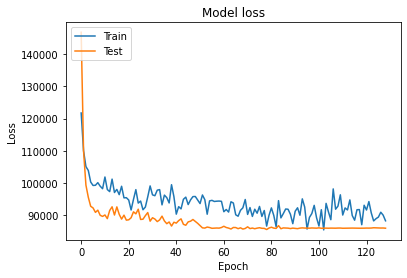

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
valid_images_RGB = load_images_in_RGB("./validationset/",IMG_SIZE)
valid_images_lab = from_RGB_to_Lab(valid_images_RGB)
valid_images_RGB = None
gc.collect()

100
100


2780

In [0]:
#Carichiamo il modello migliore
model = tf.keras.models.load_model("model.hdf5", custom_objects={"categorical_crossentropy_color":categorical_crossentropy_color})

!rm -d -r "immagini_salvate"
!mkdir "immagini_salvate"
save_images(valid_images_lab,model,"immagini_salvate/")
!zip -r -9 immagini_salvate_PNG.zip immagini_salvate/*

rm: cannot remove 'immagini_salvate': No such file or directory
SALVATAGGIO IMMAGINI RGB...
IMMAGINE RGB N 0 SALVATA
IMMAGINE RGB N 1 SALVATA


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 30 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


IMMAGINE RGB N 2 SALVATA
IMMAGINE RGB N 3 SALVATA


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 35 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


IMMAGINE RGB N 4 SALVATA
IMMAGINE RGB N 5 SALVATA
IMMAGINE RGB N 6 SALVATA
IMMAGINE RGB N 7 SALVATA


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


IMMAGINE RGB N 8 SALVATA
IMMAGINE RGB N 9 SALVATA
IMMAGINE RGB N 10 SALVATA


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 33 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


IMMAGINE RGB N 11 SALVATA


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


IMMAGINE RGB N 12 SALVATA


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 3 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


IMMAGINE RGB N 13 SALVATA
IMMAGINE RGB N 14 SALVATA


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


IMMAGINE RGB N 15 SALVATA
IMMAGINE RGB N 16 SALVATA
IMMAGINE RGB N 17 SALVATA
IMMAGINE RGB N 18 SALVATA
IMMAGINE RGB N 19 SALVATA


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 4589 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


IMMAGINE RGB N 20 SALVATA
IMMAGINE RGB N 21 SALVATA
IMMAGINE RGB N 22 SALVATA
IMMAGINE RGB N 23 SALVATA
IMMAGINE RGB N 24 SALVATA
IMMAGINE RGB N 25 SALVATA
IMMAGINE RGB N 26 SALVATA
IMMAGINE RGB N 27 SALVATA
IMMAGINE RGB N 28 SALVATA
IMMAGINE RGB N 29 SALVATA


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 9 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


IMMAGINE RGB N 30 SALVATA
IMMAGINE RGB N 31 SALVATA
IMMAGINE RGB N 32 SALVATA
IMMAGINE RGB N 33 SALVATA
IMMAGINE RGB N 34 SALVATA
IMMAGINE RGB N 35 SALVATA
IMMAGINE RGB N 36 SALVATA
IMMAGINE RGB N 37 SALVATA
IMMAGINE RGB N 38 SALVATA
IMMAGINE RGB N 39 SALVATA


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 19 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


IMMAGINE RGB N 40 SALVATA
IMMAGINE RGB N 41 SALVATA
IMMAGINE RGB N 42 SALVATA


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 13 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


IMMAGINE RGB N 43 SALVATA
IMMAGINE RGB N 44 SALVATA


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 18 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


IMMAGINE RGB N 45 SALVATA
IMMAGINE RGB N 46 SALVATA
IMMAGINE RGB N 47 SALVATA
IMMAGINE RGB N 48 SALVATA
IMMAGINE RGB N 49 SALVATA
IMMAGINE RGB N 50 SALVATA
IMMAGINE RGB N 51 SALVATA
IMMAGINE RGB N 52 SALVATA
IMMAGINE RGB N 53 SALVATA
IMMAGINE RGB N 54 SALVATA


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 687 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


IMMAGINE RGB N 55 SALVATA


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 72 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


IMMAGINE RGB N 56 SALVATA
IMMAGINE RGB N 57 SALVATA
IMMAGINE RGB N 58 SALVATA
IMMAGINE RGB N 59 SALVATA
IMMAGINE RGB N 60 SALVATA
IMMAGINE RGB N 61 SALVATA
IMMAGINE RGB N 62 SALVATA
IMMAGINE RGB N 63 SALVATA
IMMAGINE RGB N 64 SALVATA
IMMAGINE RGB N 65 SALVATA
IMMAGINE RGB N 66 SALVATA
IMMAGINE RGB N 67 SALVATA
IMMAGINE RGB N 68 SALVATA
IMMAGINE RGB N 69 SALVATA
IMMAGINE RGB N 70 SALVATA
IMMAGINE RGB N 71 SALVATA
IMMAGINE RGB N 72 SALVATA
IMMAGINE RGB N 73 SALVATA
IMMAGINE RGB N 74 SALVATA
IMMAGINE RGB N 75 SALVATA
IMMAGINE RGB N 76 SALVATA
IMMAGINE RGB N 77 SALVATA
IMMAGINE RGB N 78 SALVATA
IMMAGINE RGB N 79 SALVATA


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 14 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


IMMAGINE RGB N 80 SALVATA


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 29 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


IMMAGINE RGB N 81 SALVATA
IMMAGINE RGB N 82 SALVATA
IMMAGINE RGB N 83 SALVATA
IMMAGINE RGB N 84 SALVATA
IMMAGINE RGB N 85 SALVATA
IMMAGINE RGB N 86 SALVATA
IMMAGINE RGB N 87 SALVATA
IMMAGINE RGB N 88 SALVATA
IMMAGINE RGB N 89 SALVATA


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 23 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


IMMAGINE RGB N 90 SALVATA
IMMAGINE RGB N 91 SALVATA
IMMAGINE RGB N 92 SALVATA
IMMAGINE RGB N 93 SALVATA
IMMAGINE RGB N 94 SALVATA
IMMAGINE RGB N 95 SALVATA
IMMAGINE RGB N 96 SALVATA


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 10 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


IMMAGINE RGB N 97 SALVATA
IMMAGINE RGB N 98 SALVATA
IMMAGINE RGB N 99 SALVATA
SALVATAGGIO IMMAGINI PNG...
IMMAGINE PNG N 0 SALVATA
IMMAGINE PNG N 1 SALVATA
IMMAGINE PNG N 2 SALVATA
IMMAGINE PNG N 3 SALVATA
IMMAGINE PNG N 4 SALVATA
IMMAGINE PNG N 5 SALVATA
IMMAGINE PNG N 6 SALVATA
IMMAGINE PNG N 7 SALVATA
IMMAGINE PNG N 8 SALVATA
IMMAGINE PNG N 9 SALVATA
IMMAGINE PNG N 10 SALVATA
IMMAGINE PNG N 11 SALVATA
IMMAGINE PNG N 12 SALVATA
IMMAGINE PNG N 13 SALVATA
IMMAGINE PNG N 14 SALVATA
IMMAGINE PNG N 15 SALVATA
IMMAGINE PNG N 16 SALVATA
IMMAGINE PNG N 17 SALVATA
IMMAGINE PNG N 18 SALVATA
IMMAGINE PNG N 19 SALVATA
IMMAGINE PNG N 20 SALVATA
IMMAGINE PNG N 21 SALVATA
IMMAGINE PNG N 22 SALVATA
IMMAGINE PNG N 23 SALVATA
IMMAGINE PNG N 24 SALVATA
IMMAGINE PNG N 25 SALVATA
IMMAGINE PNG N 26 SALVATA
IMMAGINE PNG N 27 SALVATA
IMMAGINE PNG N 28 SALVATA
IMMAGINE PNG N 29 SALVATA
IMMAGINE PNG N 30 SALVATA
IMMAGINE PNG N 31 SALVATA
IMMAGINE PNG N 32 SALVATA
IMMAGINE PNG N 33 SALVATA
IMMAGINE PNG N 34 SA

In [0]:
#Visualizziamo come la rete ha colorato le immagini
def visualize(images,model,figsize):
  images_L = images[:,:,:,:1]
  images_ab = images[:,:,:,1:3]
  images_L_preprocessed = (images_L - train_mean)/train_std

  #otteniamo i valori di probabilità dalla rete
  prob_predicted = model.predict(images_L_preprocessed)

  #trasformiamo le probabilità
  prob_predicted = trasform_probabilities(prob_predicted)
  
  #da ogni classe otteniamo un valore dei componenti ab per ogni pixel
  images_ab_predicted = decode_prob_in_ab(prob_predicted)

  #riportiamo l'output della rete alla dimensione originale delle immagini
  images_ab_predicted_resized = resize_images_ab(images_ab_predicted,IMG_SIZE)

  #mettiamo insieme la componente L con le componenti a,b
  images_predicted = np.concatenate((images_L,images_ab_predicted_resized),axis=3)

  for i in range(0, images_predicted.shape[0]):
    fig, axes = plt.subplots(1, 2, figsize=(figsize, figsize))
    ax = axes.ravel()

    #print("BIANCO E NERO")
    ax[0].imshow(rgb2gray(skimage.color.lab2rgb(images[i])),cmap=plt.cm.gray)
    ax[0].set_title("BIANCO E NERO")

    #print("OUTPUT RETE")
    ax[1].imshow(skimage.color.lab2rgb(images_predicted[i]))
    ax[1].set_title("OUTPUT RETE")

    fig.tight_layout()
    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


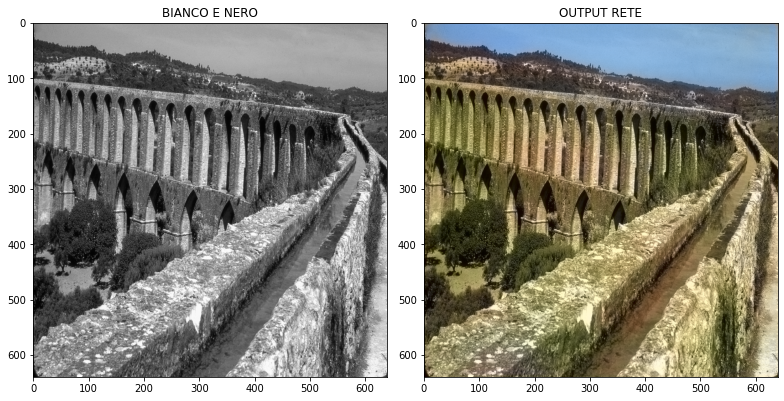

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 30 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


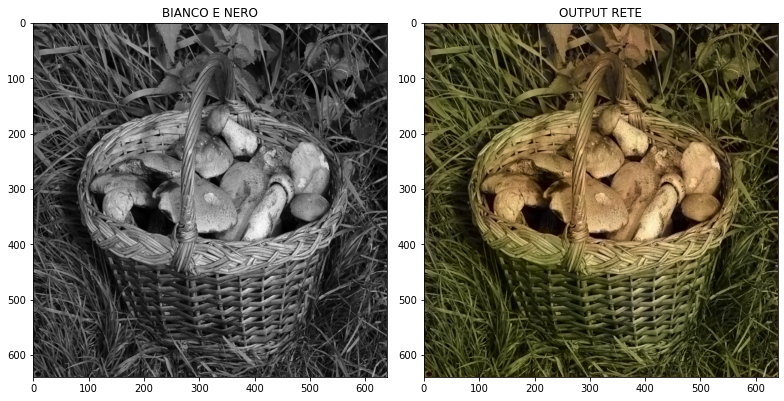

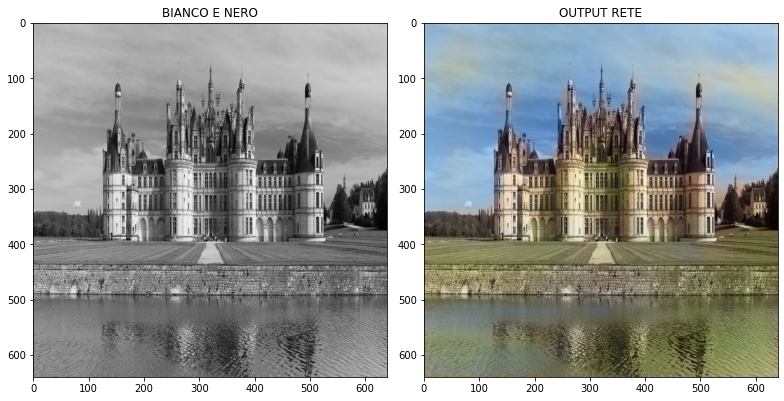

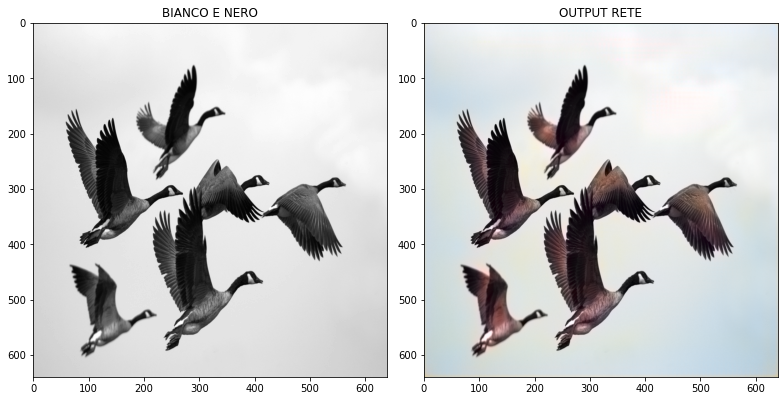

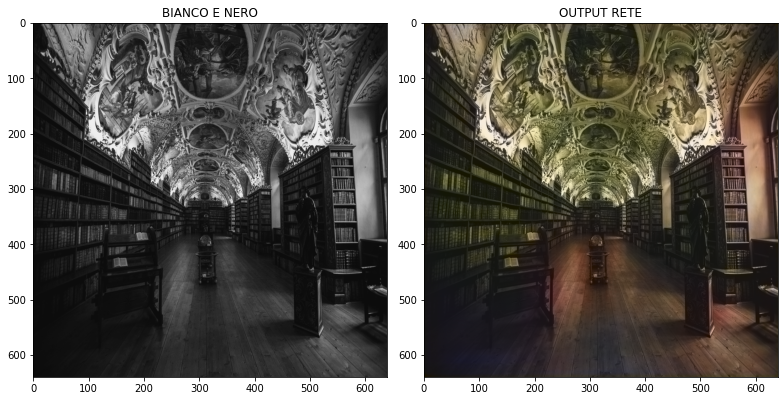

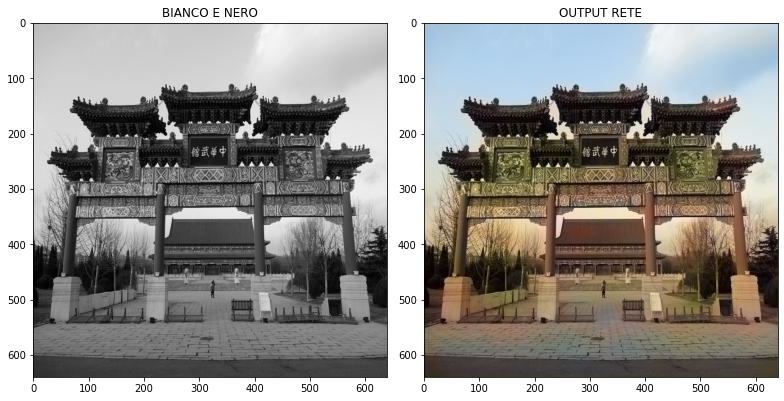

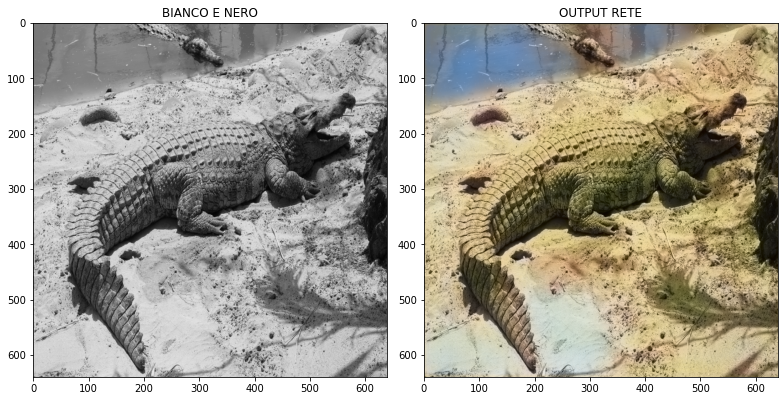

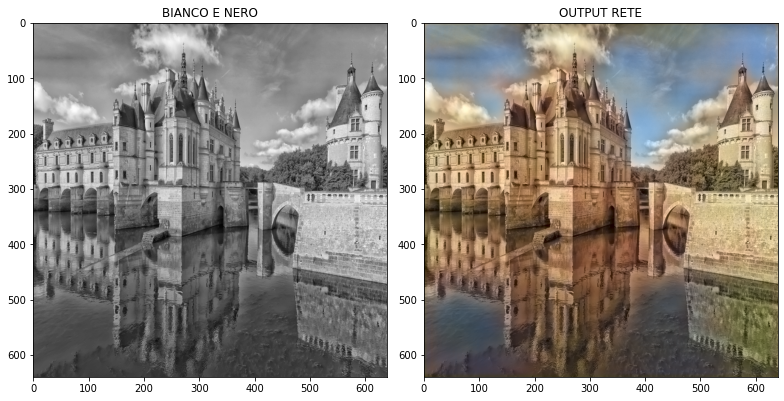

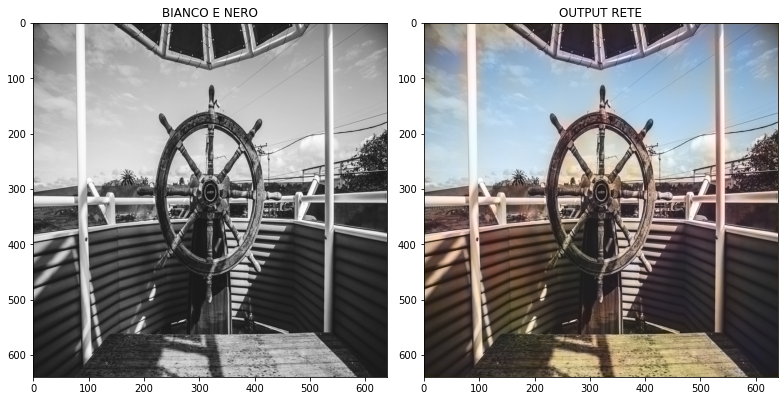

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 19 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


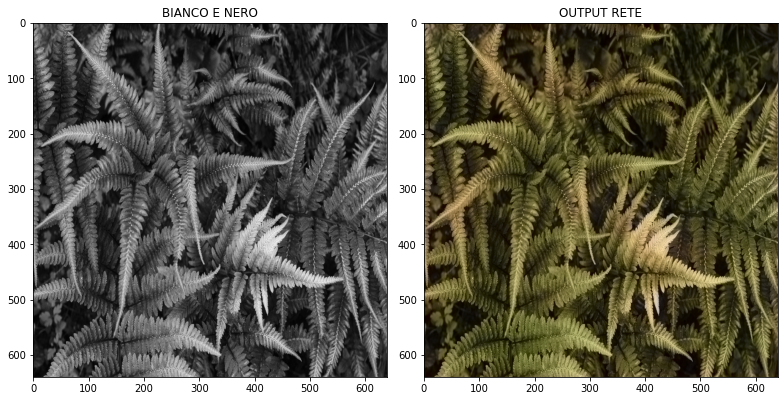

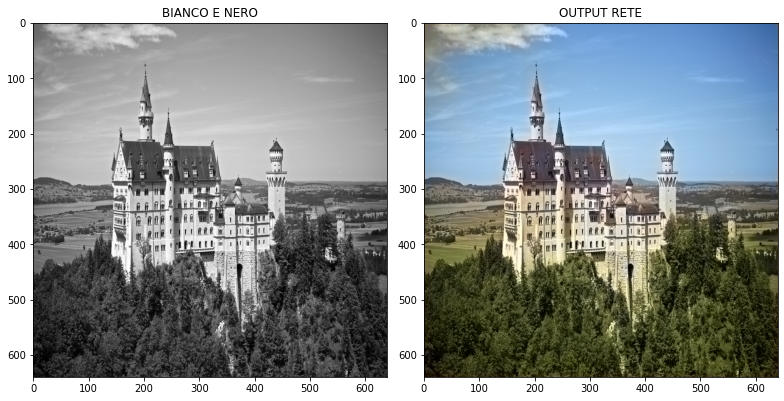

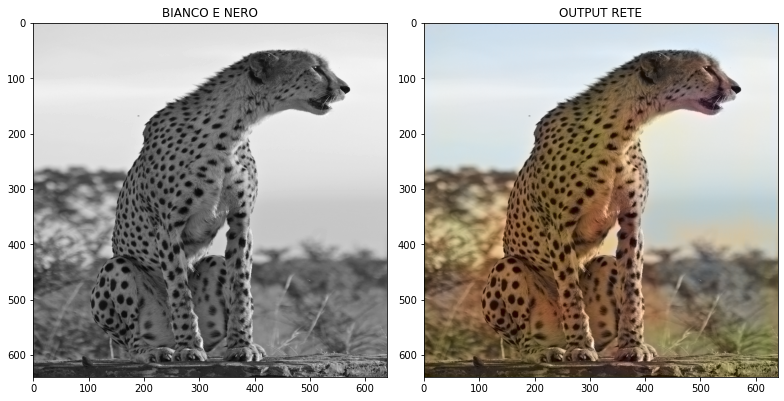

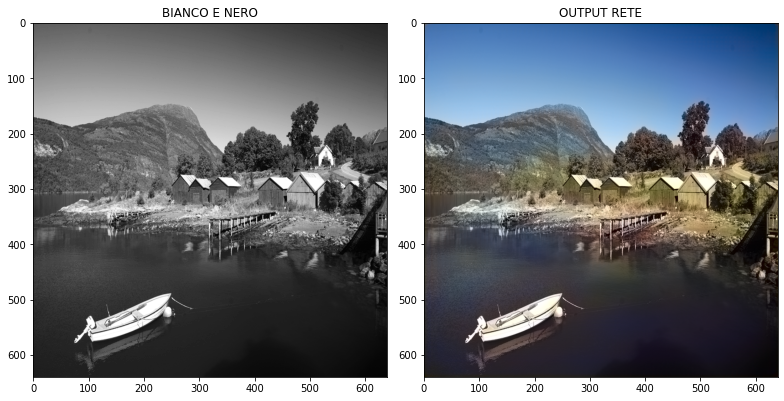

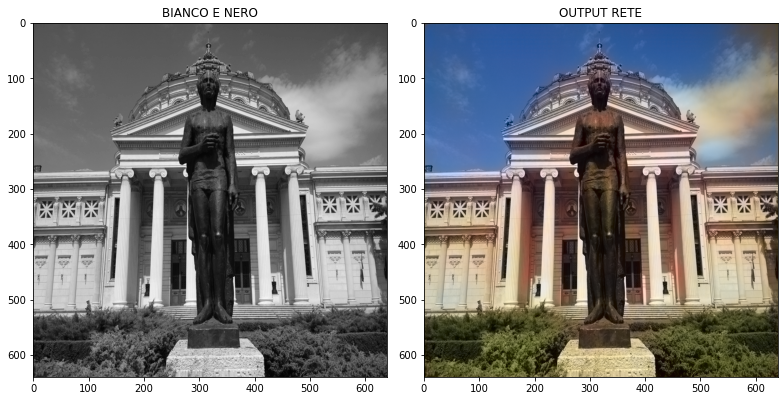

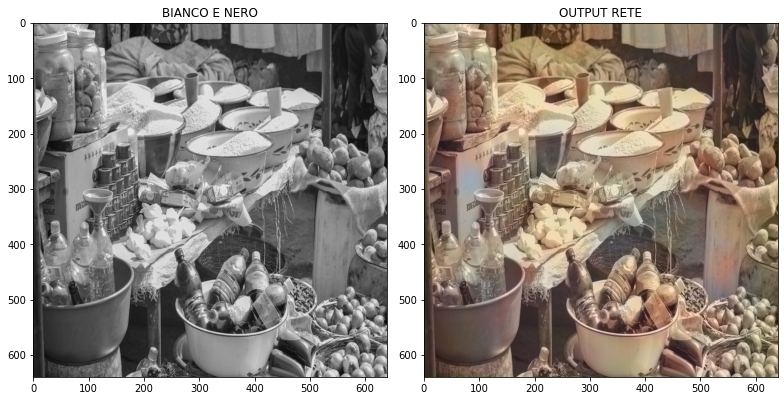

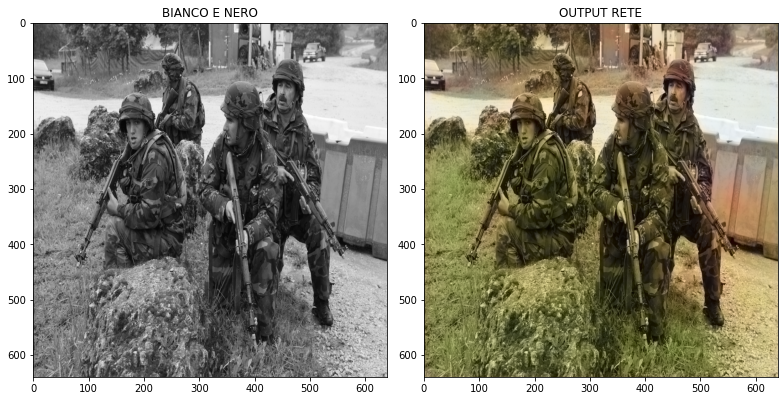

In [0]:
show_imgs = np.take(valid_images_lab, [3, 2, 5, 8, 16, 22, 28, 35, 38, 40, 46, 78, 88, 94, 74, 62], axis = 0)
visualize(show_imgs,model,11)

# visualize(valid_images_lab[50:55], model, 11)